In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data = btc_data[['Close']].rename(columns={'Close': 'y'})
btc_data['ds'] = btc_data.index

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data[['y']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape((X.shape[0], X.shape[1]))

split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

svm_model = SVR(kernel='rbf', C=100, gamma=0.1)  
svm_model.fit(X_train, y_train)

svm_train_forecast = svm_model.predict(X_train)
svm_test_forecast = svm_model.predict(X_test)

svm_train_forecast_rescaled = scaler.inverse_transform(svm_train_forecast.reshape(-1, 1))
svm_test_forecast_rescaled = scaler.inverse_transform(svm_test_forecast.reshape(-1, 1))
y_train_rescaled = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

def predict_future_svm(model, last_sequence, future_steps):
    predictions = []
    current_input = last_sequence
    
    for _ in range(future_steps):
        next_pred = model.predict(current_input.reshape(1, -1))
        predictions.append(next_pred[0])
        
        current_input = np.append(current_input[1:], next_pred)
        
    return np.array(predictions)

last_sequence = X_test[-1]  
future_steps = 30
future_predictions_scaled = predict_future_svm(svm_model, last_sequence, future_steps)
future_predictions_rescaled = scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))

test_dates = btc_data['ds'].iloc[-len(y_test_rescaled):]
future_dates = pd.date_range(test_dates.iloc[-1], periods=future_steps + 1, freq='D')[1:]

[*********************100%***********************]  1 of 1 completed
c:\Users\mungi\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


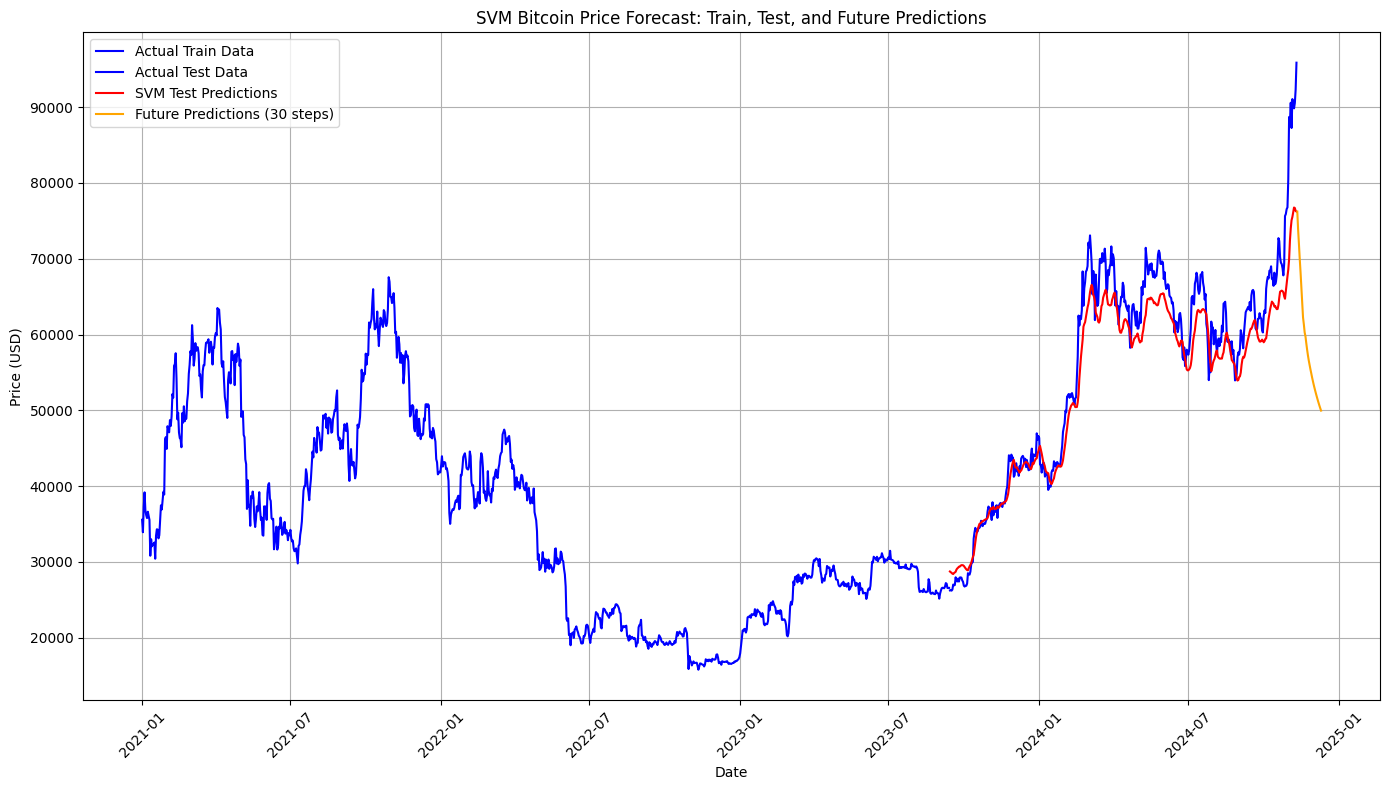

SVM Train RMSE: 2960.7817504086024
SVM Test RMSE: 4251.810926832077
SVM Train R2 Score: 0.9487781033626133
SVM Test R2 Score: 0.9126850935914383
SVM Train MAE: 2518.4828292763646
SVM Test MAE: 3076.2829630283554


In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

train_dates = btc_data['ds'][:len(y_train_rescaled)]
test_dates = btc_data['ds'][len(y_train_rescaled):len(y_train_rescaled) + len(y_test_rescaled)]
future_dates = pd.date_range(test_dates.iloc[-1], periods=future_steps + 1, freq='D')[1:]

plt.figure(figsize=(14, 8))

plt.plot(train_dates, y_train_rescaled, label='Actual Train Data', color='blue')

plt.plot(test_dates, y_test_rescaled, label='Actual Test Data', color='blue')
plt.plot(test_dates, svm_test_forecast_rescaled, label='SVM Test Predictions', color='red')

plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions (30 steps)', color='orange')

plt.title('SVM Bitcoin Price Forecast: Train, Test, and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rmse_train = np.sqrt(mean_squared_error(y_train_rescaled, svm_train_forecast_rescaled))
rmse_test = np.sqrt(mean_squared_error(y_test_rescaled, svm_test_forecast_rescaled))

r2_train = r2_score(y_train_rescaled, svm_train_forecast_rescaled)
r2_test = r2_score(y_test_rescaled, svm_test_forecast_rescaled)

mae_train = mean_absolute_error(y_train_rescaled, svm_train_forecast_rescaled)
mae_test = mean_absolute_error(y_test_rescaled, svm_test_forecast_rescaled)

print(f'SVM Train RMSE: {rmse_train}')
print(f'SVM Test RMSE: {rmse_test}')
print(f'SVM Train R2 Score: {r2_train}')
print(f'SVM Test R2 Score: {r2_test}')
print(f'SVM Train MAE: {mae_train}')
print(f'SVM Test MAE: {mae_test}')


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)
btc_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

btc_data = btc_data.dropna()
btc_data['ds'] = pd.to_datetime(btc_data['ds'])
btc_data['y'] = btc_data['y'].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data[['y']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs Available:", len(gpus))
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Using CPU.")

model_hybrid = Sequential()
model_hybrid.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_hybrid.add(MaxPooling1D(pool_size=2))

model_hybrid.add(GRU(50, return_sequences=True))
model_hybrid.add(GRU(25))

model_hybrid.add(Dense(1))
model_hybrid.compile(optimizer='adam', loss='mean_squared_error')


[*********************100%***********************]  1 of 1 completed


GPUs Available: 1


In [7]:

history = model_hybrid.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, verbose=1)

forecast_hybrid = model_hybrid.predict(X_test)
forecast_hybrid = scaler.inverse_transform(forecast_hybrid)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
rmse_hybrid = np.sqrt(mean_squared_error(y_test_actual, forecast_hybrid))
mae_hybrid = mean_absolute_error(y_test_actual, forecast_hybrid)
print(f"Hybrid GRU-1D CNN RMSE: {rmse_hybrid}")
print(f"Hybrid GRU-1D CNN MAE: {mae_hybrid}")

def predict_future(model, last_sequence, future_steps):
    predictions = []
    current_sequence = last_sequence
    for _ in range(future_steps):
        pred = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        current_sequence = np.append(current_sequence[1:], pred, axis=0)
    return np.array(predictions)

last_sequence = scaled_data[-seq_length:]
future_steps = 30
future_predictions = predict_future(model_hybrid, last_sequence, future_steps)
future_predictions = scaler.inverse_transform(future_predictions.reshape(-1, 1))


Epoch 1/1000
28/28 [==============================] - 19s 109ms/step - loss: 0.0213 - val_loss: 1.9417e-04
Epoch 2/1000
28/28 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 2.8113e-04
Epoch 3/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 1.8490e-04
Epoch 4/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 4.4577e-04
Epoch 5/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 1.9509e-04
Epoch 6/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 1.8808e-04
Epoch 7/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 1.9534e-04
Epoch 8/1000
28/28 [==============================] - 1s 19ms/step - loss: 0.0011 - val_loss: 1.7223e-04
Epoch 9/1000
28/28 [==============================] - 1s 21ms/step - loss: 0.0011 - val_loss: 1.6743e-04
Epoch 10/1000
28/28 [==============================] 

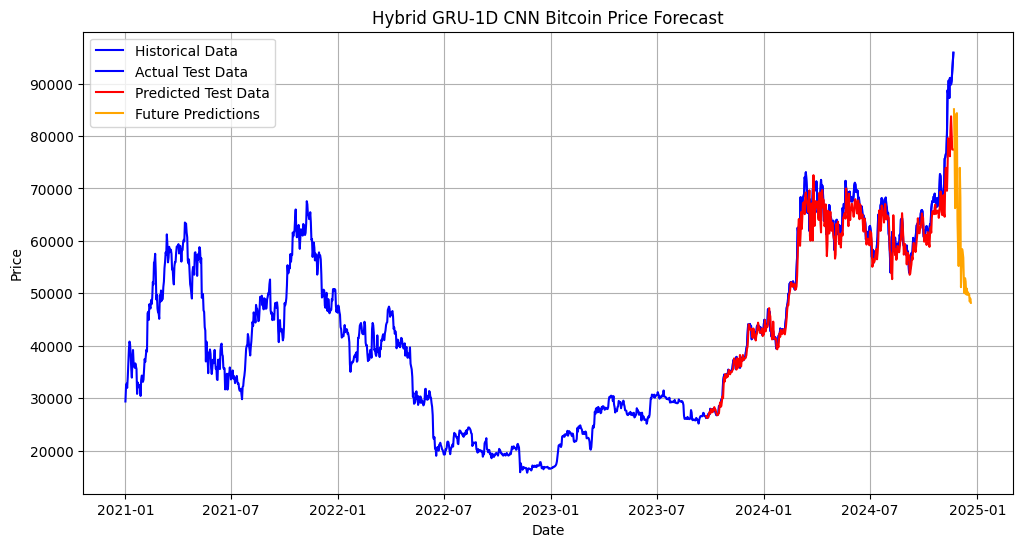

In [8]:
plt.figure(figsize=(12, 6))

plt.plot(btc_data['ds'], btc_data['y'], label="Historical Data", color='blue')

test_dates = btc_data['ds'].iloc[split+seq_length:]
plt.plot(test_dates, y_test_actual, label="Actual Test Data", color='blue')
plt.plot(test_dates, forecast_hybrid, label="Predicted Test Data", color='red')

future_dates = btc_data['ds'].iloc[-1] + pd.to_timedelta(np.arange(1, future_steps + 1), unit='D')
plt.plot(future_dates, future_predictions, label="Future Predictions", color='orange')

plt.title('Hybrid GRU-1D CNN Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

forecast_hybrid = model_hybrid.predict(X_test)  
forecast_hybrid = scaler.inverse_transform(forecast_hybrid) 

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_hybrid = np.sqrt(mean_squared_error(y_test_actual, forecast_hybrid))

mae_hybrid = mean_absolute_error(y_test_actual, forecast_hybrid)

r2_hybrid = r2_score(y_test_actual, forecast_hybrid)

print(f"Hybrid GRU-1D CNN RMSE: {rmse_hybrid}")
print(f"Hybrid GRU-1D CNN MAE: {mae_hybrid}")
print(f"Hybrid GRU-1D CNN R² Score: {r2_hybrid}")


13/13 [==============================] - 0s 7ms/step
Hybrid GRU-1D CNN RMSE: 2784.0676940030116
Hybrid GRU-1D CNN MAE: 1962.5085869311097
Hybrid GRU-1D CNN R² Score: 0.9647725961923099


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)
btc_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

btc_data = btc_data.dropna()
btc_data['ds'] = pd.to_datetime(btc_data['ds'])
btc_data['y'] = btc_data['y'].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data[['y']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.GRU(25),
    tf.keras.layers.Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')


[*********************100%***********************]  1 of 1 completed


In [12]:

history = model_gru.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, verbose=1)

forecast_gru = model_gru.predict(X_test)
forecast_gru = scaler.inverse_transform(forecast_gru)  

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_gru = np.sqrt(mean_squared_error(y_test_actual, forecast_gru))

mae_gru = mean_absolute_error(y_test_actual, forecast_gru)

r2_gru = r2_score(y_test_actual, forecast_gru)

print(f"GRU Model RMSE: {rmse_gru}")
print(f"GRU Model MAE: {mae_gru}")
print(f"GRU Model R² Score: {r2_gru}")

def predict_future_gru(model, last_sequence, future_steps):
    predictions = []
    current_sequence = last_sequence
    for _ in range(future_steps):
        pred = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        current_sequence = np.append(current_sequence[1:], pred, axis=0)
    return np.array(predictions)

last_sequence = scaled_data[-seq_length:]
future_steps = 30
future_predictions_gru = predict_future_gru(model_gru, last_sequence, future_steps)
future_predictions_gru = scaler.inverse_transform(future_predictions_gru.reshape(-1, 1))


Epoch 1/1000
28/28 [==============================] - 0s 15ms/step - loss: 3.1807e-04 - val_loss: 3.8866e-05
Epoch 2/1000
28/28 [==============================] - 1s 20ms/step - loss: 3.1902e-04 - val_loss: 3.9013e-05
Epoch 3/1000
28/28 [==============================] - 0s 17ms/step - loss: 3.3216e-04 - val_loss: 3.3813e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 3.5157e-04 - val_loss: 6.4292e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 3.3193e-04 - val_loss: 3.7887e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 3.1933e-04 - val_loss: 4.2415e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 3.2475e-04 - val_loss: 3.3323e-05
Epoch 8/1000
28/28 [==============================] - 0s 10ms/step - loss: 3.1139e-04 - val_loss: 5.6975e-05
Epoch 9/1000
28/28 [==============================] - 0s 10ms/step - loss: 3.1588e-04 - val_loss: 6.3144e-05
Epoch 10/1000
28/28

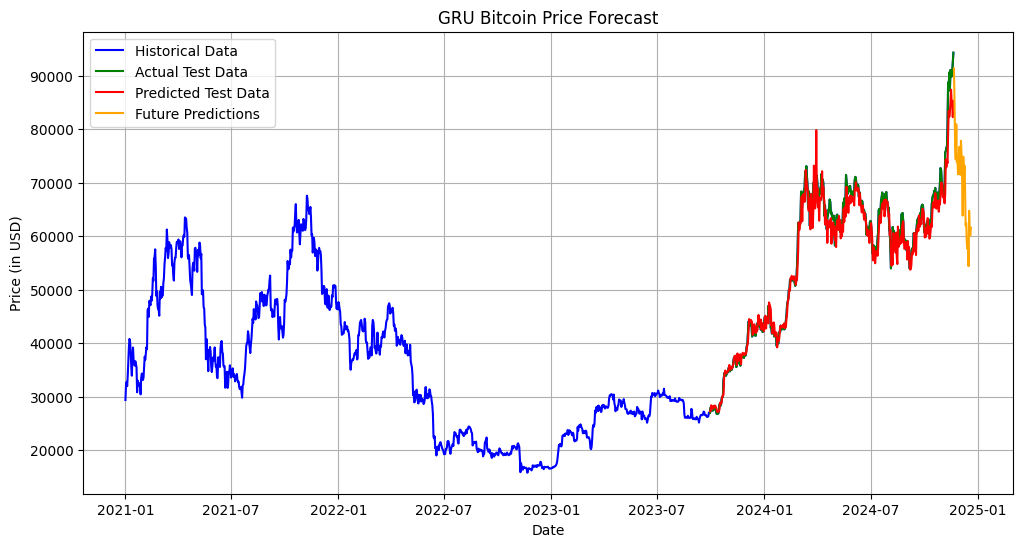

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'btc_data' contains the historical Bitcoin data, 'forecast_gru' is the predicted data, 
# 'y_test_actual' contains the actual test data, and 'future_predictions_gru' contains the future predictions

plt.figure(figsize=(12, 6))

# Plot Historical Data
plt.plot(btc_data['ds'], btc_data['y'], label="Historical Data", color='blue')

# Plot Actual Test Data
test_dates = btc_data['ds'].iloc[split + seq_length:]  # Adjusting for correct test data index
plt.plot(test_dates, y_test_actual, label="Actual Test Data", color='green')

# Plot Predicted Test Data
plt.plot(test_dates, forecast_gru, label="Predicted Test Data", color='red')

# Plot Future Predictions
# Calculate future dates starting from the last date of btc_data and extending by future_steps
future_dates = pd.date_range(btc_data['ds'].iloc[-1], periods=future_steps + 1, freq='D')[1:]
plt.plot(future_dates, future_predictions_gru, label="Future Predictions", color='orange')

# Title and labels
plt.title('GRU Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (in USD)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [4]:
print(f"GRU Model RMSE: {rmse_gru}")
print(f"GRU Model MAE: {mae_gru}")
print(f"GRU Model R² Score: {r2_gru}")

GRU Model RMSE: 2531.091699467278
GRU Model MAE: 1882.6815284838517
GRU Model R² Score: 0.9674944078339117


In [5]:
import pickle
pickle.dump(model_gru,open('bitcoin_model_gru.pkl','wb'))

INFO:tensorflow:Assets written to: ram://0b8d7926-7a97-4713-be60-078e1c8db26f/assets


INFO:tensorflow:Assets written to: ram://0b8d7926-7a97-4713-be60-078e1c8db26f/assets


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)
btc_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

btc_data = btc_data.dropna()
btc_data['ds'] = pd.to_datetime(btc_data['ds'])
btc_data['y'] = btc_data['y'].astype(float)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_data[['y']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
    tf.keras.layers.Dense(1)
])

model_bilstm.compile(optimizer='adam', loss='mean_squared_error')


[*********************100%***********************]  1 of 1 completed


In [2]:

history = model_bilstm.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, verbose=1)

forecast_bilstm = model_bilstm.predict(X_test)
forecast_bilstm = scaler.inverse_transform(forecast_bilstm)  

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_bilstm = np.sqrt(mean_squared_error(y_test_actual, forecast_bilstm))

mae_bilstm = mean_absolute_error(y_test_actual, forecast_bilstm)

r2_bilstm = r2_score(y_test_actual, forecast_bilstm)

print(f"Bi-LSTM Model RMSE: {rmse_bilstm}")
print(f"Bi-LSTM Model MAE: {mae_bilstm}")
print(f"Bi-LSTM Model R² Score: {r2_bilstm}")

def predict_future_bilstm(model, last_sequence, future_steps):
    predictions = []
    current_sequence = last_sequence
    for _ in range(future_steps):
        pred = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(pred[0, 0])
        current_sequence = np.append(current_sequence[1:], pred, axis=0)
    return np.array(predictions)

last_sequence = scaled_data[-seq_length:]
future_steps = 30
future_predictions_bilstm = predict_future_bilstm(model_bilstm, last_sequence, future_steps)
future_predictions_bilstm = scaler.inverse_transform(future_predictions_bilstm.reshape(-1, 1))


Epoch 1/1000
28/28 [==============================] - 12s 111ms/step - loss: 0.0169 - val_loss: 4.7023e-04
Epoch 2/1000
28/28 [==============================] - 0s 18ms/step - loss: 0.0028 - val_loss: 3.0050e-04
Epoch 3/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 2.3105e-04
Epoch 4/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 2.0975e-04
Epoch 5/1000
28/28 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 1.4476e-04
Epoch 6/1000
28/28 [==============================] - 0s 16ms/step - loss: 9.6120e-04 - val_loss: 2.1580e-04
Epoch 7/1000
28/28 [==============================] - 0s 16ms/step - loss: 8.4653e-04 - val_loss: 2.2236e-04
Epoch 8/1000
28/28 [==============================] - 0s 17ms/step - loss: 8.6855e-04 - val_loss: 8.7517e-05
Epoch 9/1000
28/28 [==============================] - 0s 16ms/step - loss: 8.0061e-04 - val_loss: 1.3849e-04
Epoch 10/1000
28/28 [================

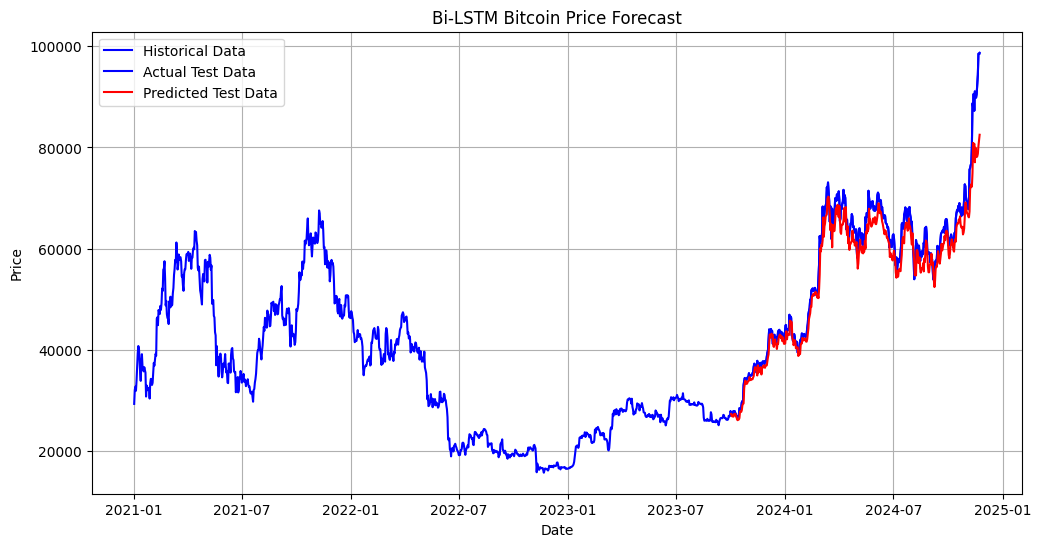

In [10]:

plt.figure(figsize=(12, 6))
plt.plot(btc_data['ds'], btc_data['y'], label="Historical Data", color='blue')

test_dates = btc_data['ds'].iloc[split+seq_length:]
plt.plot(test_dates, y_test_actual, label="Actual Test Data", color='blue')
plt.plot(test_dates, forecast_bilstm, label="Predicted Test Data", color='red')

future_dates = btc_data['ds'].iloc[-1] + pd.to_timedelta(np.arange(1, future_steps + 1), unit='D')
#plt.plot(future_dates, future_predictions_bilstm, label="Future Predictions", color='orange')
plt.title('Bi-LSTM Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
!pip install plotly


  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/b6/cb/b86984bed139586d01532a587464b5805f12e397594f19f931c4c2fbfa61/tenacity-9.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 19.1/19.1 MB 213.5 kB/s eta 0:00:00


In [35]:
pip install nbformat


Note: you may need to restart the kernel to use updated packages.


In [12]:
pip uninstall xgboost

^C
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install catboost


  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/93/04/5de8b41397d4c3a6eece31db76229203ee12d835d0af930955fb6cd03c24/catboost-1.2.7-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   -------------------------------------- 101.8/101.8 MB 864.6 kB/s eta 0:00:00
   ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


CatBoost Model RMSE: 6026.902728850931
CatBoost Model MAE: 3133.9863072844773
CatBoost Model R² Score: 0.8199521569354294


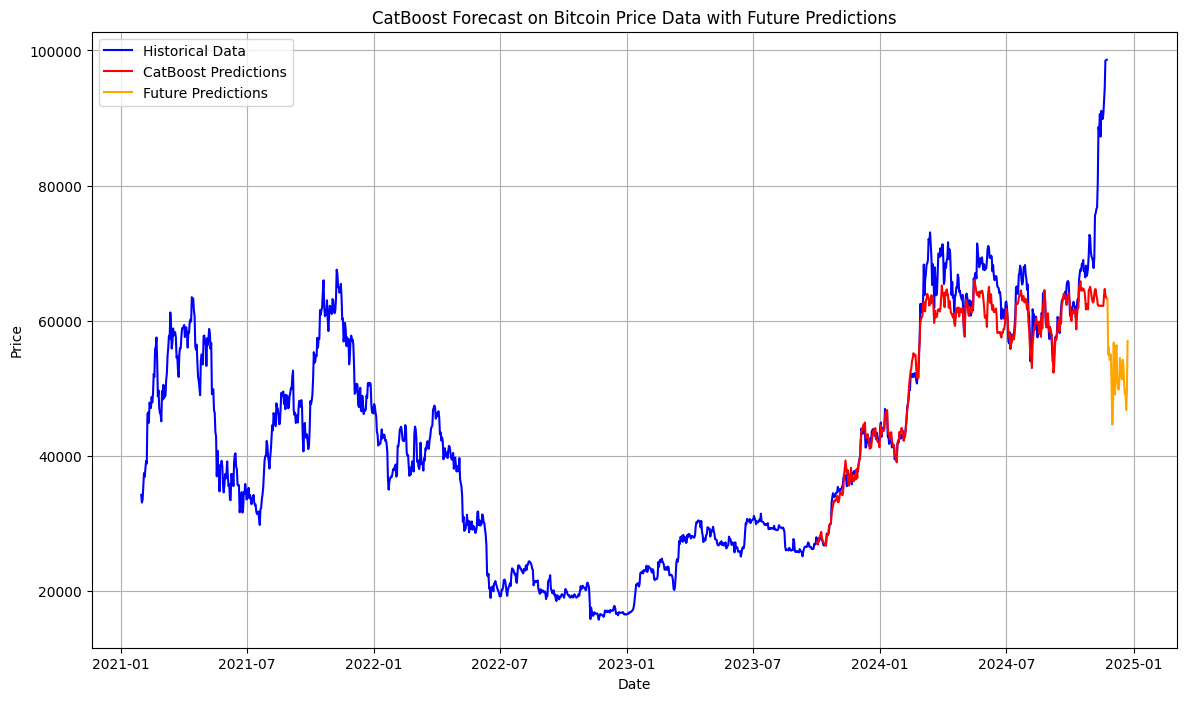

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)

btc_data = btc_data[['Date', 'Close']].dropna()
btc_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

for lag in range(1, 21):
    btc_data[f'lag_{lag}'] = btc_data['y'].shift(lag)

btc_data['MA_3'] = btc_data['y'].rolling(window=3).mean()
btc_data['MA_5'] = btc_data['y'].rolling(window=5).mean()
btc_data['MA_15'] = btc_data['y'].rolling(window=15).mean()
btc_data['MA_30'] = btc_data['y'].rolling(window=30).mean()

btc_data['MA_20'] = btc_data['y'].rolling(window=20).mean()
btc_data['BB_upper'] = btc_data['MA_20'] + (2 * btc_data['y'].rolling(window=20).std())
btc_data['BB_lower'] = btc_data['MA_20'] - (2 * btc_data['y'].rolling(window=20).std())

btc_data['volatility'] = btc_data['y'].rolling(window=10).std()

delta = btc_data['y'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
btc_data['RSI'] = 100 - (100 / (1 + rs))

btc_data.dropna(inplace=True)

X = btc_data.drop(columns=['ds', 'y'])
y = btc_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=7, verbose=0)
cat_model.fit(X_train, y_train)

y_pred = cat_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"CatBoost Model RMSE: {rmse}")
print(f"CatBoost Model MAE: {mae}")
print(f"CatBoost Model R² Score: {r2}")

n_future_steps = 30  
last_known = X.iloc[-1].values.reshape(1, -1)

future_predictions = []

for _ in range(n_future_steps):
    next_pred = cat_model.predict(last_known)[0]
    future_predictions.append(next_pred)

    last_known = np.roll(last_known, shift=-1)
    last_known[0, -1] = next_pred  

last_date = btc_data['ds'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_steps)

future_df = pd.DataFrame({'ds': future_dates, 'y': future_predictions})

plt.figure(figsize=(14, 8))
plt.plot(btc_data['ds'], btc_data['y'], label='Historical Data', color='blue')
plt.plot(btc_data['ds'][len(X_train):], y_pred, label='CatBoost Predictions', color='red')

plt.plot(future_df['ds'], future_df['y'], label='Future Predictions', color='orange')

plt.title('CatBoost Forecast on Bitcoin Price Data with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\mungi\anaconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[*********************100%***********************]  1 of 1 completed
07:22:21 - cmdstanpy - INFO - Chain [1] start processing
07:22:21 - cmdstanpy - INFO - Chain [1] done processing


Close Price Model RMSE: 12302.859859558233
Close Price Model MAE: 10064.50985416544
Close Price Model R² Score: 0.2987874107227574


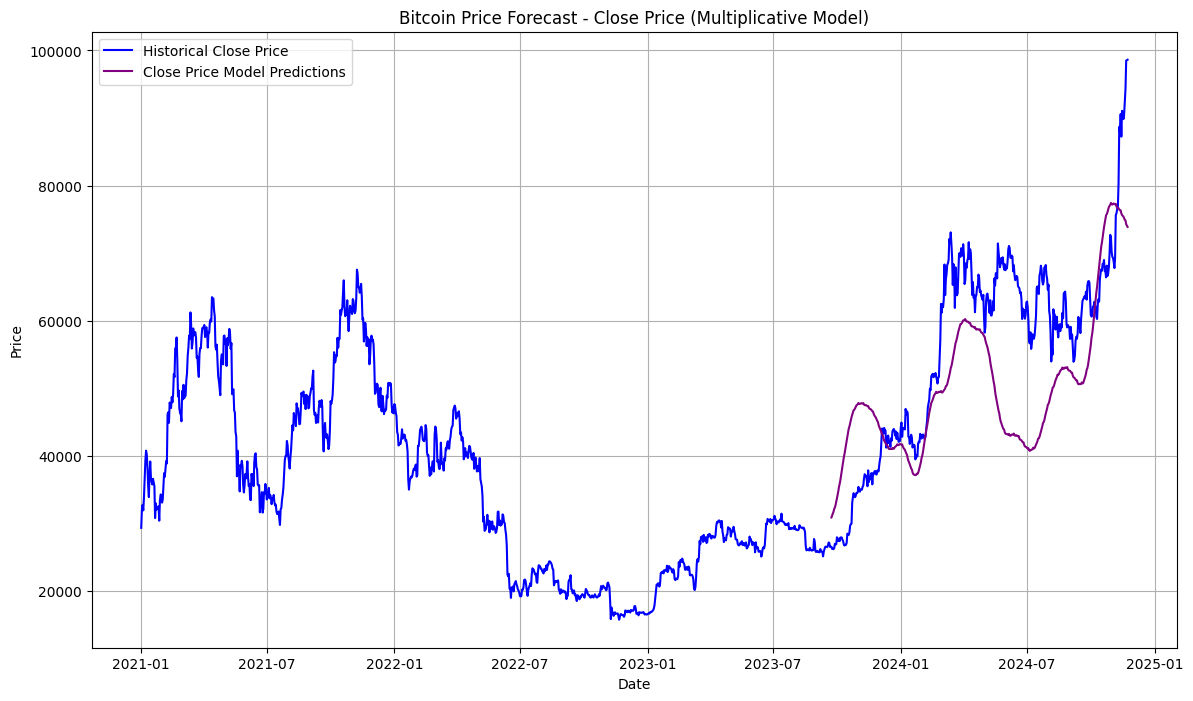

In [5]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)

btc_data_close = btc_data[['Date', 'Close']].dropna()
btc_data_close.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

split = int(0.7 * len(btc_data_close))
train_data_close = btc_data_close[:split]
test_data_close = btc_data_close[split:]

multiplicative_model_close = Prophet(seasonality_mode='multiplicative')
multiplicative_model_close.fit(train_data_close)

future_close = multiplicative_model_close.make_future_dataframe(periods=len(test_data_close), freq='D')
forecast_close = multiplicative_model_close.predict(future_close)

y_test_actual_close = test_data_close['y'].values
y_pred_close = forecast_close['yhat'].values[-len(test_data_close):]

rmse_close = np.sqrt(mean_squared_error(y_test_actual_close, y_pred_close))
mae_close = mean_absolute_error(y_test_actual_close, y_pred_close)
r2_close = r2_score(y_test_actual_close, y_pred_close)

print(f"Close Price Model RMSE: {rmse_close}")
print(f"Close Price Model MAE: {mae_close}")
print(f"Close Price Model R² Score: {r2_close}")

plt.figure(figsize=(14, 8))
plt.plot(btc_data_close['ds'], btc_data_close['y'], label="Historical Close Price", color='blue')
plt.plot(test_data_close['ds'], y_pred_close, label="Close Price Model Predictions", color='purple')
plt.title('Bitcoin Price Forecast - Close Price (Multiplicative Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
07:22:22 - cmdstanpy - INFO - Chain [1] start processing
07:22:22 - cmdstanpy - INFO - Chain [1] done processing


Close Price Model RMSE: 13913.254002263373
Close Price Model MAE: 11899.529249017238
Close Price Model R² Score: 0.1032012834649969


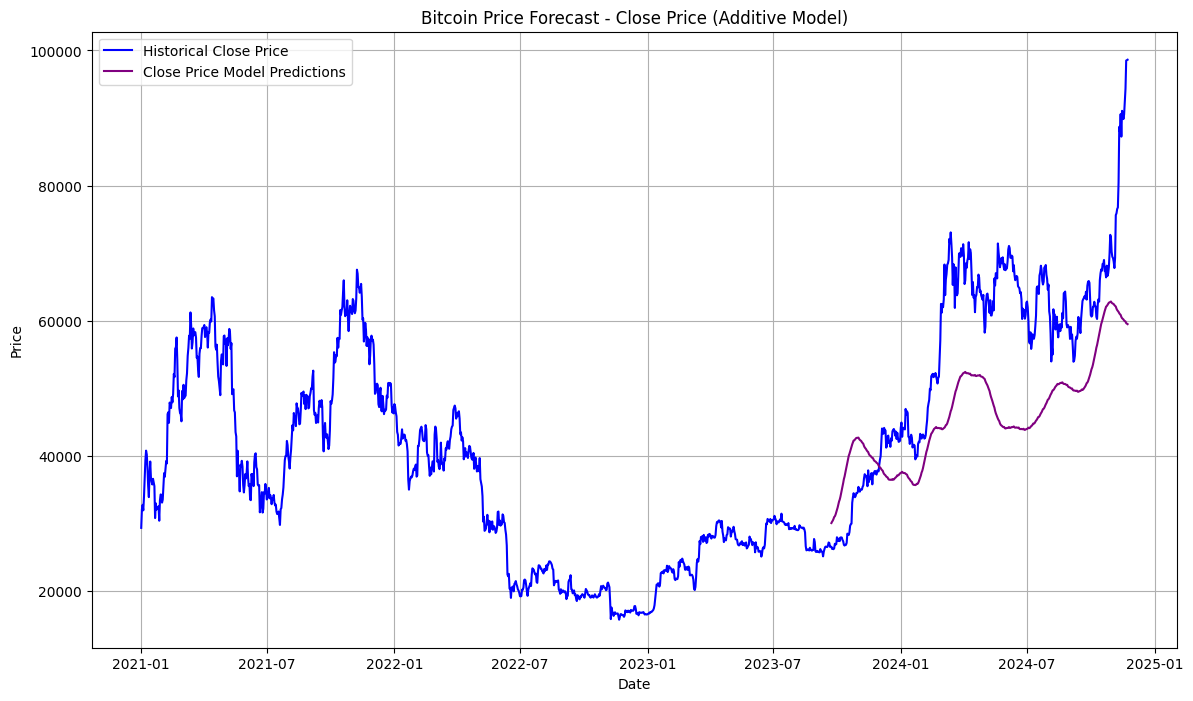

In [6]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

btc_data = yf.download('BTC-USD', start='2021-01-01')
btc_data.reset_index(inplace=True)

btc_data_close = btc_data[['Date', 'Close']].dropna()
btc_data_close.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

split = int(0.7 * len(btc_data_close))
train_data_close = btc_data_close[:split]
test_data_close = btc_data_close[split:]

multiplicative_model_close = Prophet(seasonality_mode='additive')
multiplicative_model_close.fit(train_data_close)

future_close = multiplicative_model_close.make_future_dataframe(periods=len(test_data_close), freq='D')
forecast_close = multiplicative_model_close.predict(future_close)

y_test_actual_close = test_data_close['y'].values
y_pred_close = forecast_close['yhat'].values[-len(test_data_close):]

rmse_close = np.sqrt(mean_squared_error(y_test_actual_close, y_pred_close))
mae_close = mean_absolute_error(y_test_actual_close, y_pred_close)
r2_close = r2_score(y_test_actual_close, y_pred_close)

print(f"Close Price Model RMSE: {rmse_close}")
print(f"Close Price Model MAE: {mae_close}")
print(f"Close Price Model R² Score: {r2_close}")

plt.figure(figsize=(14, 8))
plt.plot(btc_data_close['ds'], btc_data_close['y'], label="Historical Close Price", color='blue')
plt.plot(test_data_close['ds'], y_pred_close, label="Close Price Model Predictions", color='purple')
plt.title('Bitcoin Price Forecast - Close Price (Additive Model)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
